# Iris with Neural Networks

Before we have seen how to train a model to predict the Iris dataset using a Perceptron. Now we will use a Neural Network to do the same task.

In [1]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

from sklearn.metrics import accuracy_score

print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Class labels: [0 1 2]
Misclassified examples: 1
Accuracy: 0.978


Now we will use a Neural Network to do the same task.

Let's import the dataset

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1./3, random_state=1)

We have to normalize the data, transform it to a tensor, create a dataset and transform it into a DataLoader.

In [3]:
import torch

X_train_norm = (X_train - np.mean(X_train))/np.std(X_train) # Normalize
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train) # Transform to tensor

X_train_norm

tensor([[ 0.8389, -0.0275, -0.9959, -1.6585],
        [ 1.0428,  0.0234, -1.0978, -1.6585],
        [ 2.1641,  0.1763,  1.6544, -0.6391],
        [ 1.7563, -0.1804,  0.9918, -0.6901],
        [ 1.9602, -0.2824,  1.4505, -0.8430],
        [ 1.5015, -0.3333,  1.0938, -0.6391],
        [ 1.3996, -0.3333,  0.6860, -0.8430],
        [ 1.2976, -0.0275,  0.5331, -0.9449],
        [ 2.1641, -0.3333,  1.6544, -0.7411],
        [ 1.1447, -0.2314,  0.3802, -1.1488],
        [ 0.6860, -0.0275, -0.9449, -1.6585],
        [ 1.1447, -0.4862,  0.7880, -0.7411],
        [ 1.4505, -0.3843,  0.7370, -0.8430],
        [ 0.6860, -0.2314, -1.0469, -1.7094],
        [ 0.6351, -0.1295, -1.0978, -1.6585],
        [ 1.5525, -0.2314,  1.1957, -0.6391],
        [ 0.5841, -0.0275, -1.0469, -1.6075],
        [ 1.3486, -0.2314,  0.7370, -0.8430],
        [ 1.5525, -0.1295,  0.8389, -0.7411],
        [ 1.6544, -0.1804,  0.4822, -1.0469],
        [ 1.1447, -0.3333,  0.5331, -1.0978],
        [ 1.6544, -0.0785,  1.1447

In [4]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

class IrisDataset(Dataset):
    def __init__(self) -> None:
        super().__init__()
        self.X = X_train_norm
        self.y = y_train

    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return len(self.X)
    
# dataset = IrisDataset() # Create Dataset


dataset = TensorDataset(X_train_norm, y_train) # Create Dataset


batch_size = 4
torch.manual_seed(1)
train_dataloader = DataLoader(dataset,
                        batch_size, # Cantidad de elementos que se procesan juntos en la iteracion de entrenamiento
                        shuffle=True)

In [5]:
from torch import nn

class MLP(nn.Module):
    def __init__(self, num_features, num_hidden, num_classes):
        super().__init__()
        self.hidden = nn.Linear(num_features, num_hidden)
        self.output = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        x = self.hidden(x)
        x = torch.sigmoid(x)
        x = self.output(x)
        x = torch.softmax(x, dim=1)
        return x

model = MLP(
    num_features=X_train_norm.shape[1],
    num_hidden=16,
    num_classes=3
)

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dataloader:

        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)

        loss.backward() # calculate the derivatives
        optimizer.step() # update the values
        optimizer.zero_grad() # set the grads to none to lower memory footprint

        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred)==y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dataloader.dataset)
    accuracy_hist[epoch] /= len(train_dataloader.dataset)

print(loss_hist)
print(accuracy_hist)

[1.107229619026184, 1.1021606492996217, 1.09763831615448, 1.092815499305725, 1.0884524154663087, 1.0829218912124634, 1.077791223526001, 1.07167715549469, 1.0655634832382201, 1.0593457174301149, 1.051700973510742, 1.0437346386909485, 1.0350235199928284, 1.0252029132843017, 1.0147946643829346, 1.0032812404632567, 0.9915415549278259, 0.9788435316085815, 0.9662567639350891, 0.9535197472572327, 0.9419811248779297, 0.9293627572059632, 0.9191997885704041, 0.9089405274391175, 0.899495120048523, 0.8914438819885254, 0.8838665080070496, 0.8770331406593322, 0.8715518260002136, 0.865491886138916, 0.8607359910011292, 0.8556206178665161, 0.8512622213363648, 0.847061676979065, 0.8433339929580689, 0.8396888899803162, 0.8362713098526001, 0.8326792860031128, 0.8291966152191163, 0.8258632135391235, 0.8233445405960083, 0.8196199727058411, 0.8160264968872071, 0.8131487011909485, 0.8101433753967285, 0.8067970871925354, 0.8033695006370545, 0.80003422498703, 0.7970035314559937, 0.7939950704574585, 0.7921905636

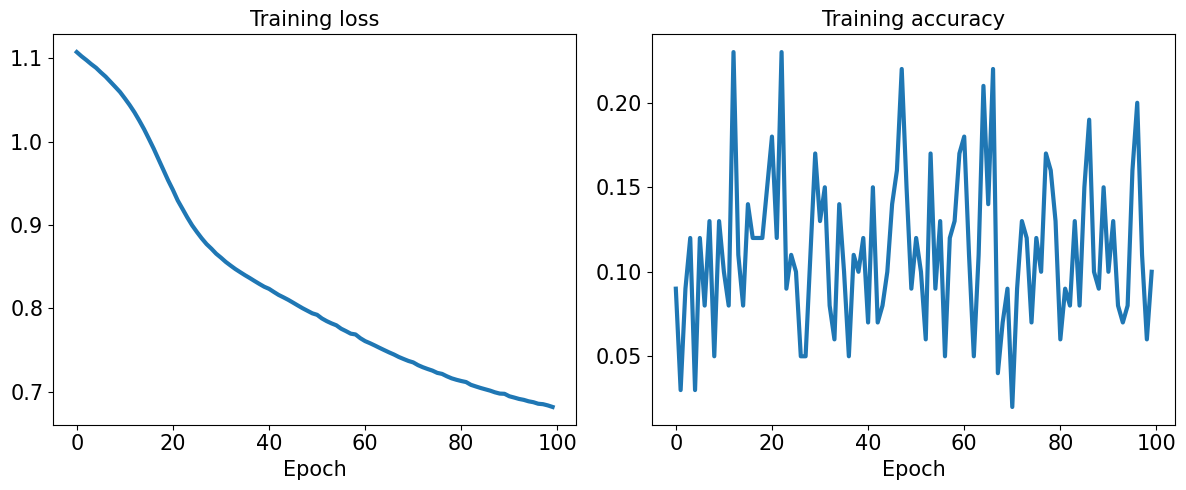

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

#plt.savefig('figures/12_09.pdf')
 
plt.show()

In [7]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test) 
pred_test = model(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')


Test Acc.: 0.9800


In [8]:
path = 'models/iris_classifier.pt'
torch.save(model, path)

In [9]:
model_new = torch.load(path)
model_new.eval()

MLP(
  (hidden): Linear(in_features=4, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=3, bias=True)
)

In [10]:
pred_test = model_new(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800
